In [1]:
# visilize the result with 24h leading time
import numpy as np
import pandas as pd
import netCDF4 as nc
import os
import re
import glob
import rasterio
import xarray as xr
import geopandas as gpd
import requests
from datetime import datetime, timedelta
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap,BoundaryNorm
import matplotlib.cm as cm
import imageio
import pygeodesy
from pygeodesy.ellipsoidalKarney import LatLon
import folium
from shapely.geometry import Point,Polygon
from folium.plugins import FastMarkerCluster

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
from cartopy.io import shapereader
from sklearn.metrics import mean_squared_error
import matplotlib.colors as mcolors
from scipy.spatial.distance import cdist
from itertools import combinations
from matplotlib.colors import to_rgb
from matplotlib.patches import Rectangle

In [2]:
# setting of the experiment
dahour = 3
exp = 'ils'
yyyymmddhh = '2019011221'
dahour_str = '{:02d}'.format(dahour)

day_sta = 11
day_end = 14
stime = 283*24+9   #20191011
sda_time = 24*(day_sta-1)
soff_time = int(sda_time/dahour)
time_len = (day_end-day_sta+1)*24
time_len_off = int((day_end-day_sta+1)*24/dahour)
var_dis  = 'outflw' # check discharge
var_dep  = 'rivdph' # check water depth
ens_num  = 20

# var_name = var_dis
var_name = var_dep

if var_name == 'outflw':
    var_ylabel = 'Outflow (kg m-2 s-1)'
    var_dir = 'dis'
else:
    var_ylabel  = 'River Depth (m)'
    var_dir = 'wlv'

In [3]:
filepath = '/work/a06/yingying/Code/plot/online/flood/'
def read_cov_tif(filename):
    filen = filepath + filename
    with rasterio.open(filen) as dataset:
        tiff_data = dataset.read(1)
        # tiff_data = tiff_data[::-1,:]
        tiff_data = np.where(tiff_data==0,np.nan,tiff_data)
        col = dataset.width      
        row = dataset.height     
        bounds = dataset.bounds
        min_lon, min_lat, max_lon, max_lat = bounds
        print(f"Longitude Range: {min_lon} to {max_lon}")
        print(f"Latitude Range: {min_lat} to {max_lat}")
        print('--------')
    return col,row,min_lon,max_lon,min_lat,max_lat,tiff_data
# 20191012T2042 -> 2019101221
col1,row1,min_lon1,max_lon1,min_lat1,max_lat1,fld_reg1 = read_cov_tif('area_1_result.tif')  # 138-138.4, 36.6-36.8
col2,row2,min_lon2,max_lon2,min_lat2,max_lat2,fld_reg2 = read_cov_tif('area_2_result.tif')  # 139.3-139.8, 34.45-35.7

# col1,row1,min_lon1,max_lon1,min_lat1,max_lat1,fld_reg1 = read_cov_tif('binary_output_without_water_area2.tif')  # 137.4-140.6, 35.9-37.8
# col2,row2,min_lon2,max_lon2,min_lat2,max_lat2,fld_reg2 = read_cov_tif('binary_output_without_water_coast.tif')  # 138.1-141.2, 34.5-36.4

lon_map1 = np.linspace(min_lon1,max_lon1,col1)
lat_map1 = np.linspace(min_lat1,max_lat1,row1)
lon2d_map1, lat2d_map1 = np.meshgrid(lon_map1, lat_map1)
lon_map2 = np.linspace(min_lon2,max_lon2,col2)
lat_map2 = np.linspace(min_lat2,max_lat2,row2)
lon2d_map2, lat2d_map2 = np.meshgrid(lon_map2, lat_map2)

Longitude Range: 137.9999237060547 to 138.40003967285156
Latitude Range: 36.599979400634766 to 36.79994201660156
--------
Longitude Range: 139.3 to 139.8
Latitude Range: 35.45 to 35.7
--------


In [4]:
#%% read tiff data
lat_min,lat_max,lon_min,lon_max = 34,37,137,141
# lat_min,lat_max,lon_min,lon_max = 33,38,137,142
def read_cov_tif(filename):
    up_area  = np.full(((lat_max-lat_min)*3600,(lon_max-lon_min)*3600),np.nan) 
    filepath = '/work/a06/yingying/SWOT/map/'+filename
    tiff_files = glob.glob(os.path.join(filepath, '*.tif'))
    for filenum in range(0,len(tiff_files)):
        filen = tiff_files[filenum]
        file_lon = int(filen[36:39])
        file_lat = int(filen[33:35])
        if (file_lat-lat_min>=0) &(file_lon-lon_min>=0) &(file_lat-lat_max<0) &(file_lon-lon_max<0):           
            with rasterio.open(filen) as dataset:
                tiff_data = dataset.read(1)
                # be care !! when drawing the figure should convert latitude tiff[::-1,:]
                up_area[(file_lat-lat_min)*3600:(file_lat-lat_min+1)*3600,(file_lon-lon_min)*3600:(file_lon-lon_min+1)*3600] = tiff_data[::-1,:]
    return up_area
up_area = read_cov_tif('wth')
#%% lower resolution
size=10
def low_resolution(var,size):
    var_low = np.full((int((lat_max-lat_min)*3600/size),int((lon_max-lon_min)*3600/size)),np.nan)
    for row in range(0,np.shape(var_low)[0]):
        if (np.all(np.isnan(var[row*size:(row+1)*size,:]))==1):
            continue
        for col in range(0,np.shape(var_low)[1]):
            var_low[row,col] = np.nanmean(var[row*size:(row+1)*size,col*size:(col+1)*size])
    return var_low    
uparea_low = low_resolution(up_area,size)
uparea_low = np.where(uparea_low<0.1,np.nan,uparea_low)
lon_tiff = np.linspace(lon_min,lon_max,int((lon_max-lon_min)*3600/size))
lat_tiff = np.linspace(lat_min,lat_max,int((lat_max-lat_min)*3600/size))

/tmp/ipykernel_2058879/1223908221.py:27: RuntimeWarning: Mean of empty slice
  var_low[row,col] = np.nanmean(var[row*size:(row+1)*size,col*size:(col+1)*size])


In [98]:
#%% read map data
map_path = '/work/a06/yingying/CaMa_v411/cmf_v411_pkg/map/tej_01min/'
def read_bin(map_path,filename):
    with open(map_path+filename, 'rb') as f:
        day_array = np.fromfile(f, dtype=np.float32)
        day_array = day_array.reshape(1320,1500)
        day_array = np.where(day_array<-999,np.nan,day_array)
        day_array = np.where(day_array>10**8,np.nan,day_array)
    return day_array

def read_nextxy(filename):
    with open(map_path+filename, 'rb') as f:
        day_array = np.fromfile(f, dtype=np.int32)
        day_array = day_array.reshape(2,1320,1500)
        day_array = np.where(day_array<-999,np.nan,day_array)
    return day_array
# read map data
basin=read_bin(map_path,'basin.bin')
elvmean = read_bin(map_path,'elv_mean.bin')
elvmean = np.where(elvmean<-100,np.nan,elvmean)
simmean = read_bin('/work/a06/yingying/camada/HydroDA/src/simmean/ils/','simmean.bin')
nextlon = read_nextxy('nextxy.bin')[0,:,:]-1
nextlat = read_nextxy('nextxy.bin')[1,:,:]-1
nextlon = np.where(nextlon<0,np.nan,nextlon)
nextlat = np.where(nextlat<0,np.nan,nextlat)

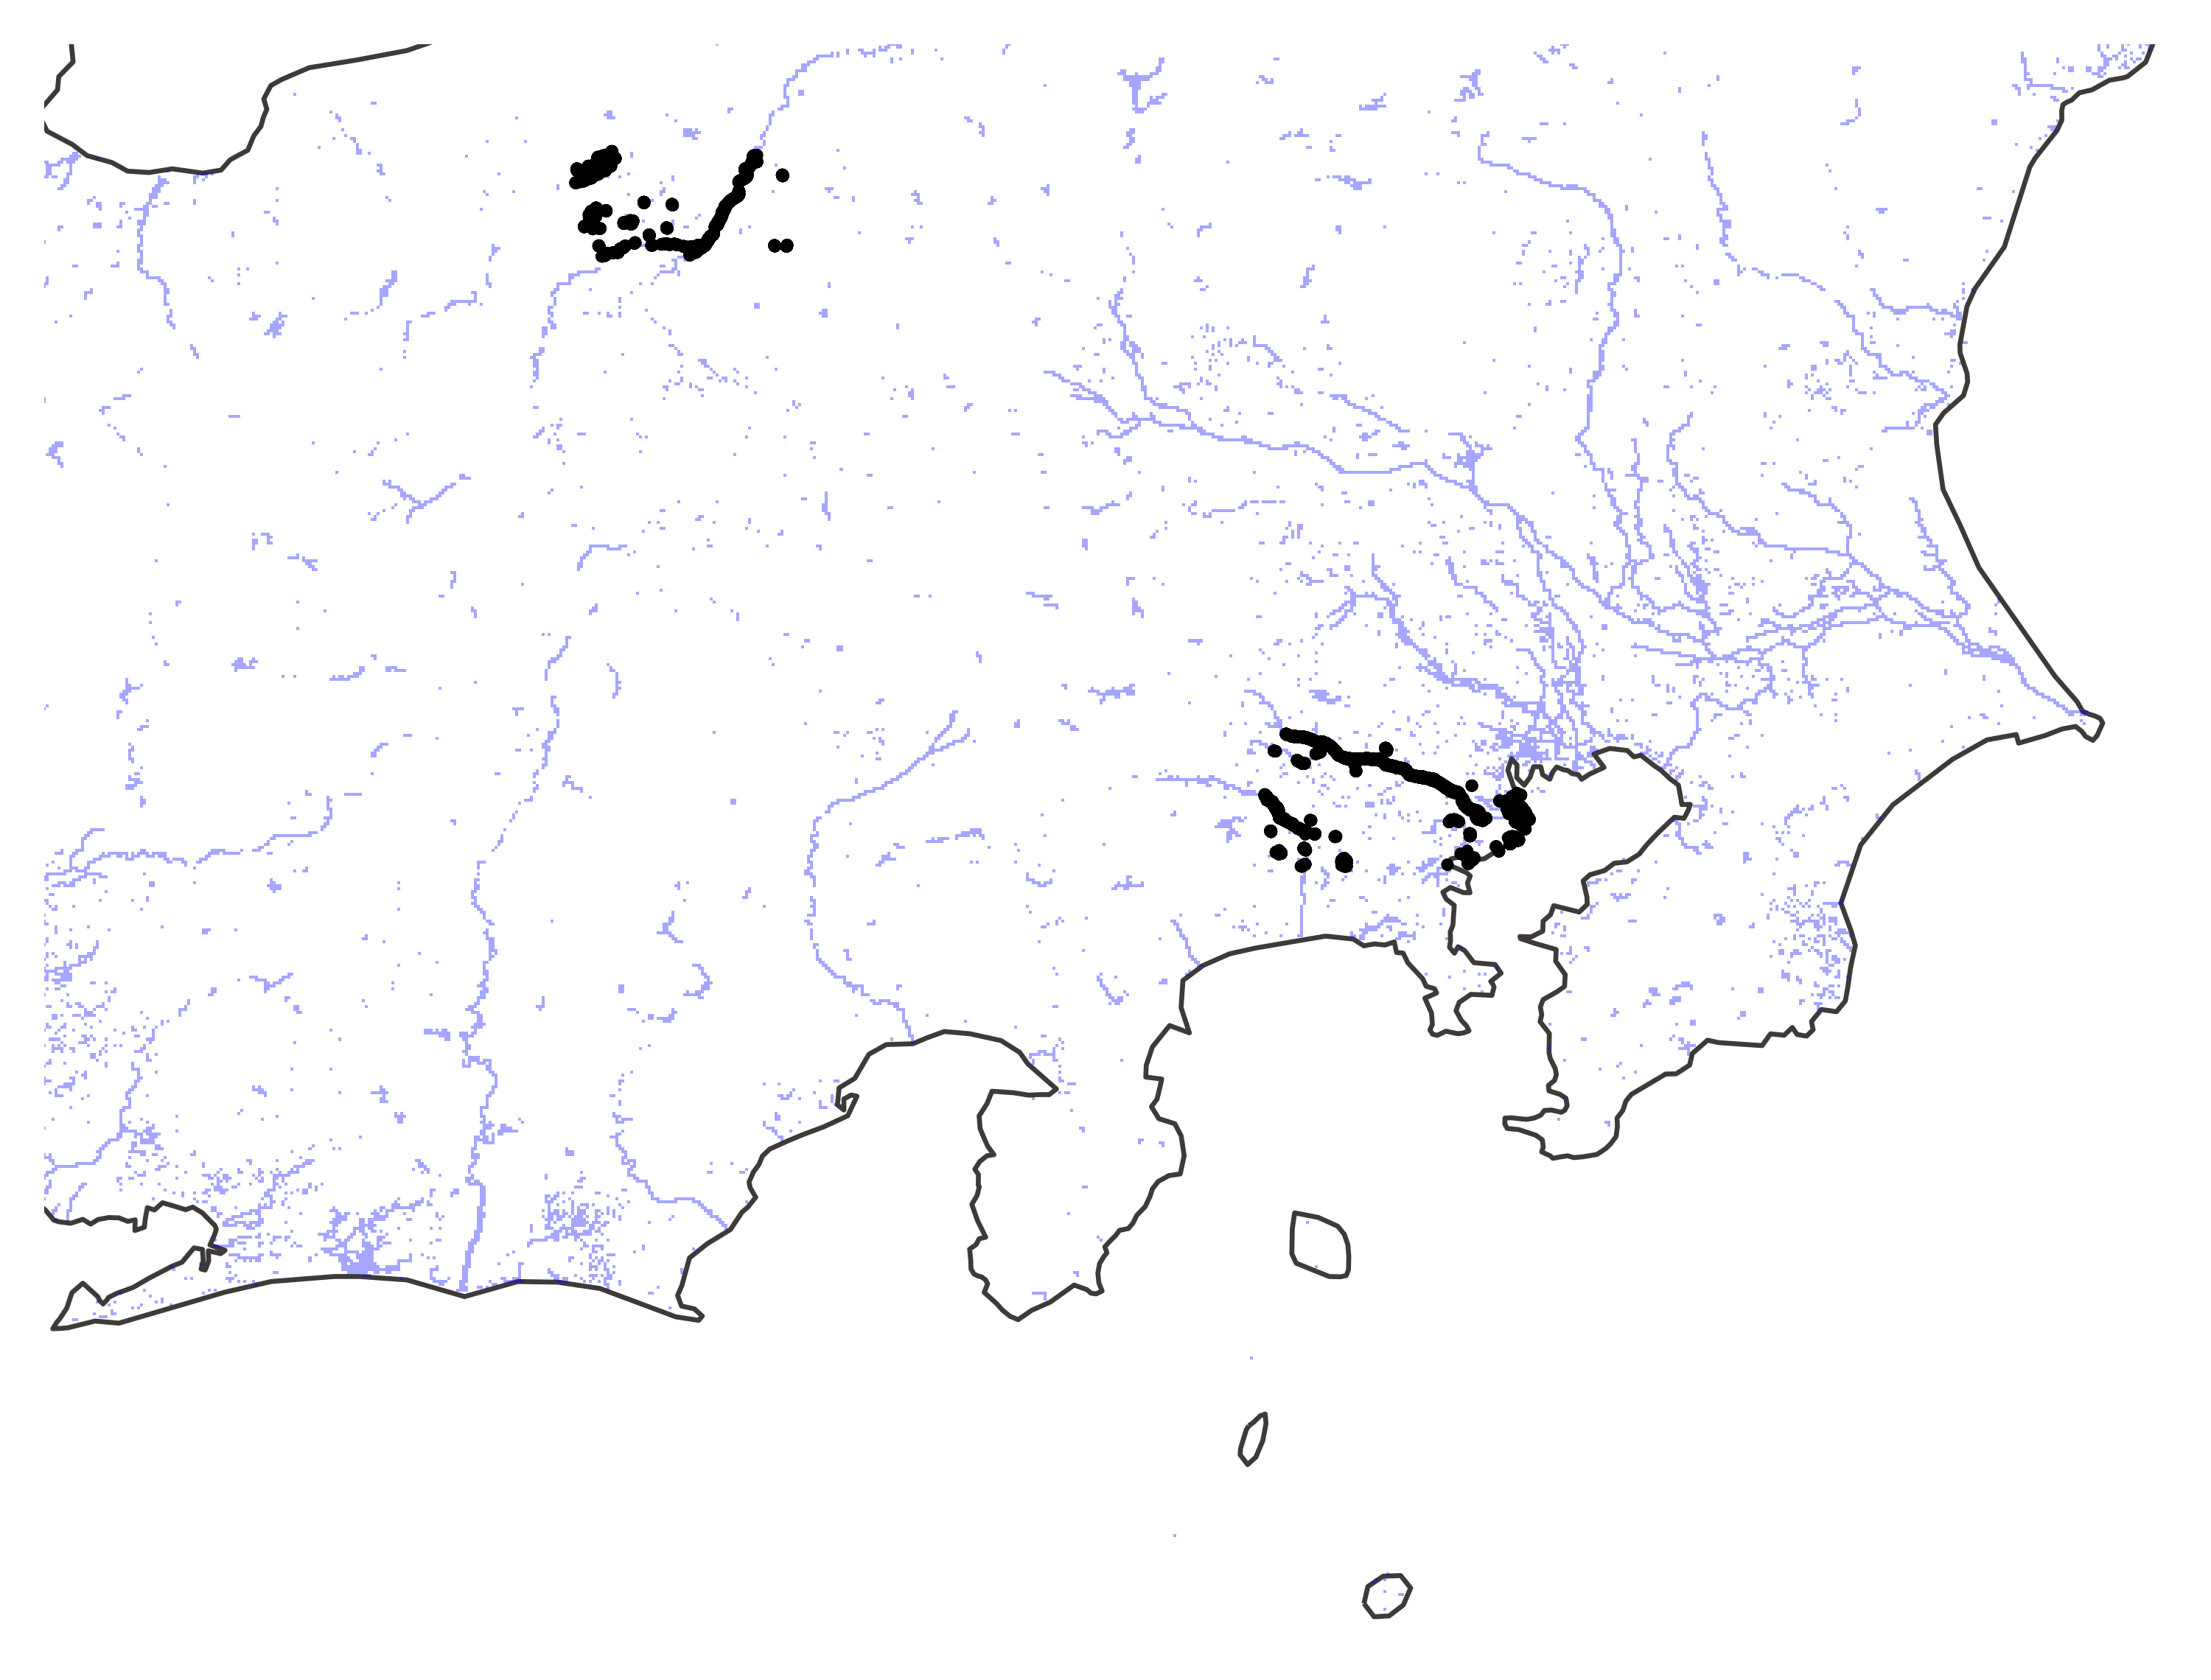

In [101]:
# Figure1: Japan map
font_label = {'family': 'serif', 'weight': 'normal', 'size': 10.5}
def draw_sat_fld():
    fig = plt.figure(dpi = 600,figsize=(6,6))
    ax1 = fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
    ax1.set_axis_off()
    ax1.set_extent([lon_min,lon_max,lat_min,lat_max], ccrs.PlateCarree())
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0, linestyle='-.')
    ax1.coastlines(alpha=1.,linestyle='-',color = "#3F3A3A",lw=0.8,resolution='10m')
    # mask the other place
    region_lon1 = [128.06, 128.06,138, 138 ]
    region_lat1 = [41 , 45.95 , 45.95, 41  ]
    region_lon2 = [128.06,128.06,131.4,131.4 ]
    region_lat2 = [34.5,41,41,34.5]
    ax1.fill(region_lon1, region_lat1, color='white', transform=ccrs.PlateCarree(), zorder=10)
    ax1.fill(region_lon2, region_lat2, color='white', transform=ccrs.PlateCarree(), zorder=10)
    cmap = ListedColormap(['blue']) 
    gl.top_labels   = False
    gl.right_labels = False
    gl.bottom_labels   = False
    gl.left_labels = False
    lon2d_tiff, lat2d_tiff = np.meshgrid(lon_tiff, lat_tiff)
    uparea_reg = np.where(np.isnan(uparea_low),np.nan,0.002)
    # ax1.scatter(lon2d_tiff, lat2d_tiff,uparea_reg, c='blue',zorder=2, transform=ccrs.PlateCarree())
    con_plot1 = ax1.pcolormesh(lon_tiff,lat_tiff,uparea_low,zorder=2, cmap=cmap,alpha=0.35, transform=ccrs.PlateCarree(),vmin=0,vmax=30)  

    def draw_sat_reg(lon2d_map,lat2d_map,data):
        # control the size for the flooding area
        ax1.scatter(lon2d_map, lat2d_map, data, color='black', zorder=3, transform=ccrs.PlateCarree())
    draw_sat_reg(lon2d_map1,lat2d_map1,fld_reg1[::-1,:])
    draw_sat_reg(lon2d_map2,lat2d_map2,fld_reg2[::-1,:])
    plt.show()
    # plt.savefig('/work/a06/yingying/swot/plot/1_Japanmap.jpg', format='jpg',dpi=600)
    plt.close()
draw_sat_fld()

In [102]:
# read sim/DA output
def read_bin(filename):
    with open(filename,'rb') as f:
        data_all = np.fromfile(f, dtype=np.float32)
        data = data_all.reshape(dahour,1320,1500)
        data = np.where(data>10**8,np.nan,data)
        f.close()
    return data
    
def read_cama(type_str):
    data_all = np.full((1320,1500,ens_num),np.nan)
    for ens in range(0,ens_num):
        ens_str = '{:03d}'.format(ens+1)
        output_path = '/work/a06/yingying/camada/HydroDA/src/CaMa_out_'+exp+dahour_str+'/'+yyyymmddhh+type_str+ens_str+'/'
        file = 'fldfrc2019.bin'
        data_day = read_bin(output_path+file)
        hh = int(yyyymmddhh[8:10])
        hh_ind = hh%dahour
        data = data_day[hh_ind,:,:]
        data_all[:,:,ens] = data
    data_mean = np.nanmean(data_all,axis=2)
    return data_mean
sim_fld = read_cama('C')
da_fld  = read_cama('A')

/tmp/ipykernel_1715549/1682397760.py:21: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data_all,axis=2)


In [103]:
# find sim/DA condition in flooding region
def read_lonlat():
    path = '/work/a06/yingying/camada/HydroDA/src/CaMa_out_ils03/2019011712A002/'
    filename = 'o_outflw2019.nc'
    nf = nc.Dataset(path+filename,'r')
    lat_all = np.array(nf.variables['lat'])
    lon_all = np.array(nf.variables['lon'])
    return lat_all,lon_all
lat_all,lon_all = read_lonlat()

def find_sim_region(min_lon,max_lon,min_lat,max_lat):
    lat_ind = np.where((lat_all>=min_lat)&(lat_all<=max_lat))[0]
    lon_ind = np.where((lon_all>=min_lon)&(lon_all<=max_lon))[0]
    lat_reg = lat_all[np.nanmin(lat_ind):np.nanmax(lat_ind)+1]
    lon_reg = lon_all[np.nanmin(lon_ind):np.nanmax(lon_ind)+1]
    lon2d_map, lat2d_map = np.meshgrid(lon_reg, lat_reg)
    sim_fld_reg = sim_fld[np.nanmin(lat_ind):np.nanmax(lat_ind)+1,np.nanmin(lon_ind):np.nanmax(lon_ind)+1]
    da_fld_reg  = da_fld[np.nanmin(lat_ind):np.nanmax(lat_ind)+1,np.nanmin(lon_ind):np.nanmax(lon_ind)+1]
    return lon2d_map, lat2d_map,sim_fld_reg,da_fld_reg
lon2d_sim1,lat2d_sim1,sim_fld_reg1,da_fld_reg1 = find_sim_region(min_lon1,max_lon1,min_lat1,max_lat1)
lon2d_sim2,lat2d_sim2,sim_fld_reg2,da_fld_reg2 = find_sim_region(min_lon2,max_lon2,min_lat2,max_lat2)

In [104]:
# upscaling for sat data
window_size = 46   #93 grids, depends on resolution
def upscale_sat(fld_reg,sim_fld_reg,da_fld_reg):
    fld_upscale = np.full((np.shape(sim_fld_reg)[0],np.shape(sim_fld_reg)[1]),np.nan)
    for i in range(0,np.shape(sim_fld_reg)[0]): # lat
        for j in range(0,np.shape(sim_fld_reg)[1]): # lon
            sim = sim_fld_reg[i,j]
            da  = da_fld_reg[i,j]
            lat_i1 = i*window_size*2-window_size
            lat_i2 = i*window_size*2+window_size
            lon_i1 = j*window_size*2-window_size
            lon_i2 = j*window_size*2+window_size
            if lat_i1<0:
                lat_i1 = 0
            if lon_i1<0:
                lon_i1 = 0            
            if lat_i2>np.shape(fld_reg)[0]:
                lat_i2 = np.shape(fld_reg)[0]    
            if lon_i2>np.shape(fld_reg)[1]:
                lon_i2 = np.shape(fld_reg)[1]
            # print(lat_i1,lat_i2,lon_i1,lon_i2]))
            fld_data = fld_reg[lat_i1:lat_i2,lon_i1:lon_i2]
            fld_upscale[i,j] = np.nansum(fld_data)/((lat_i2-lat_i1)*(lon_i2-lon_i1))
    return fld_upscale
fld_up1 = upscale_sat(fld_reg1,sim_fld_reg1,da_fld_reg1)
fld_up2 = upscale_sat(fld_reg2,sim_fld_reg2,da_fld_reg2)

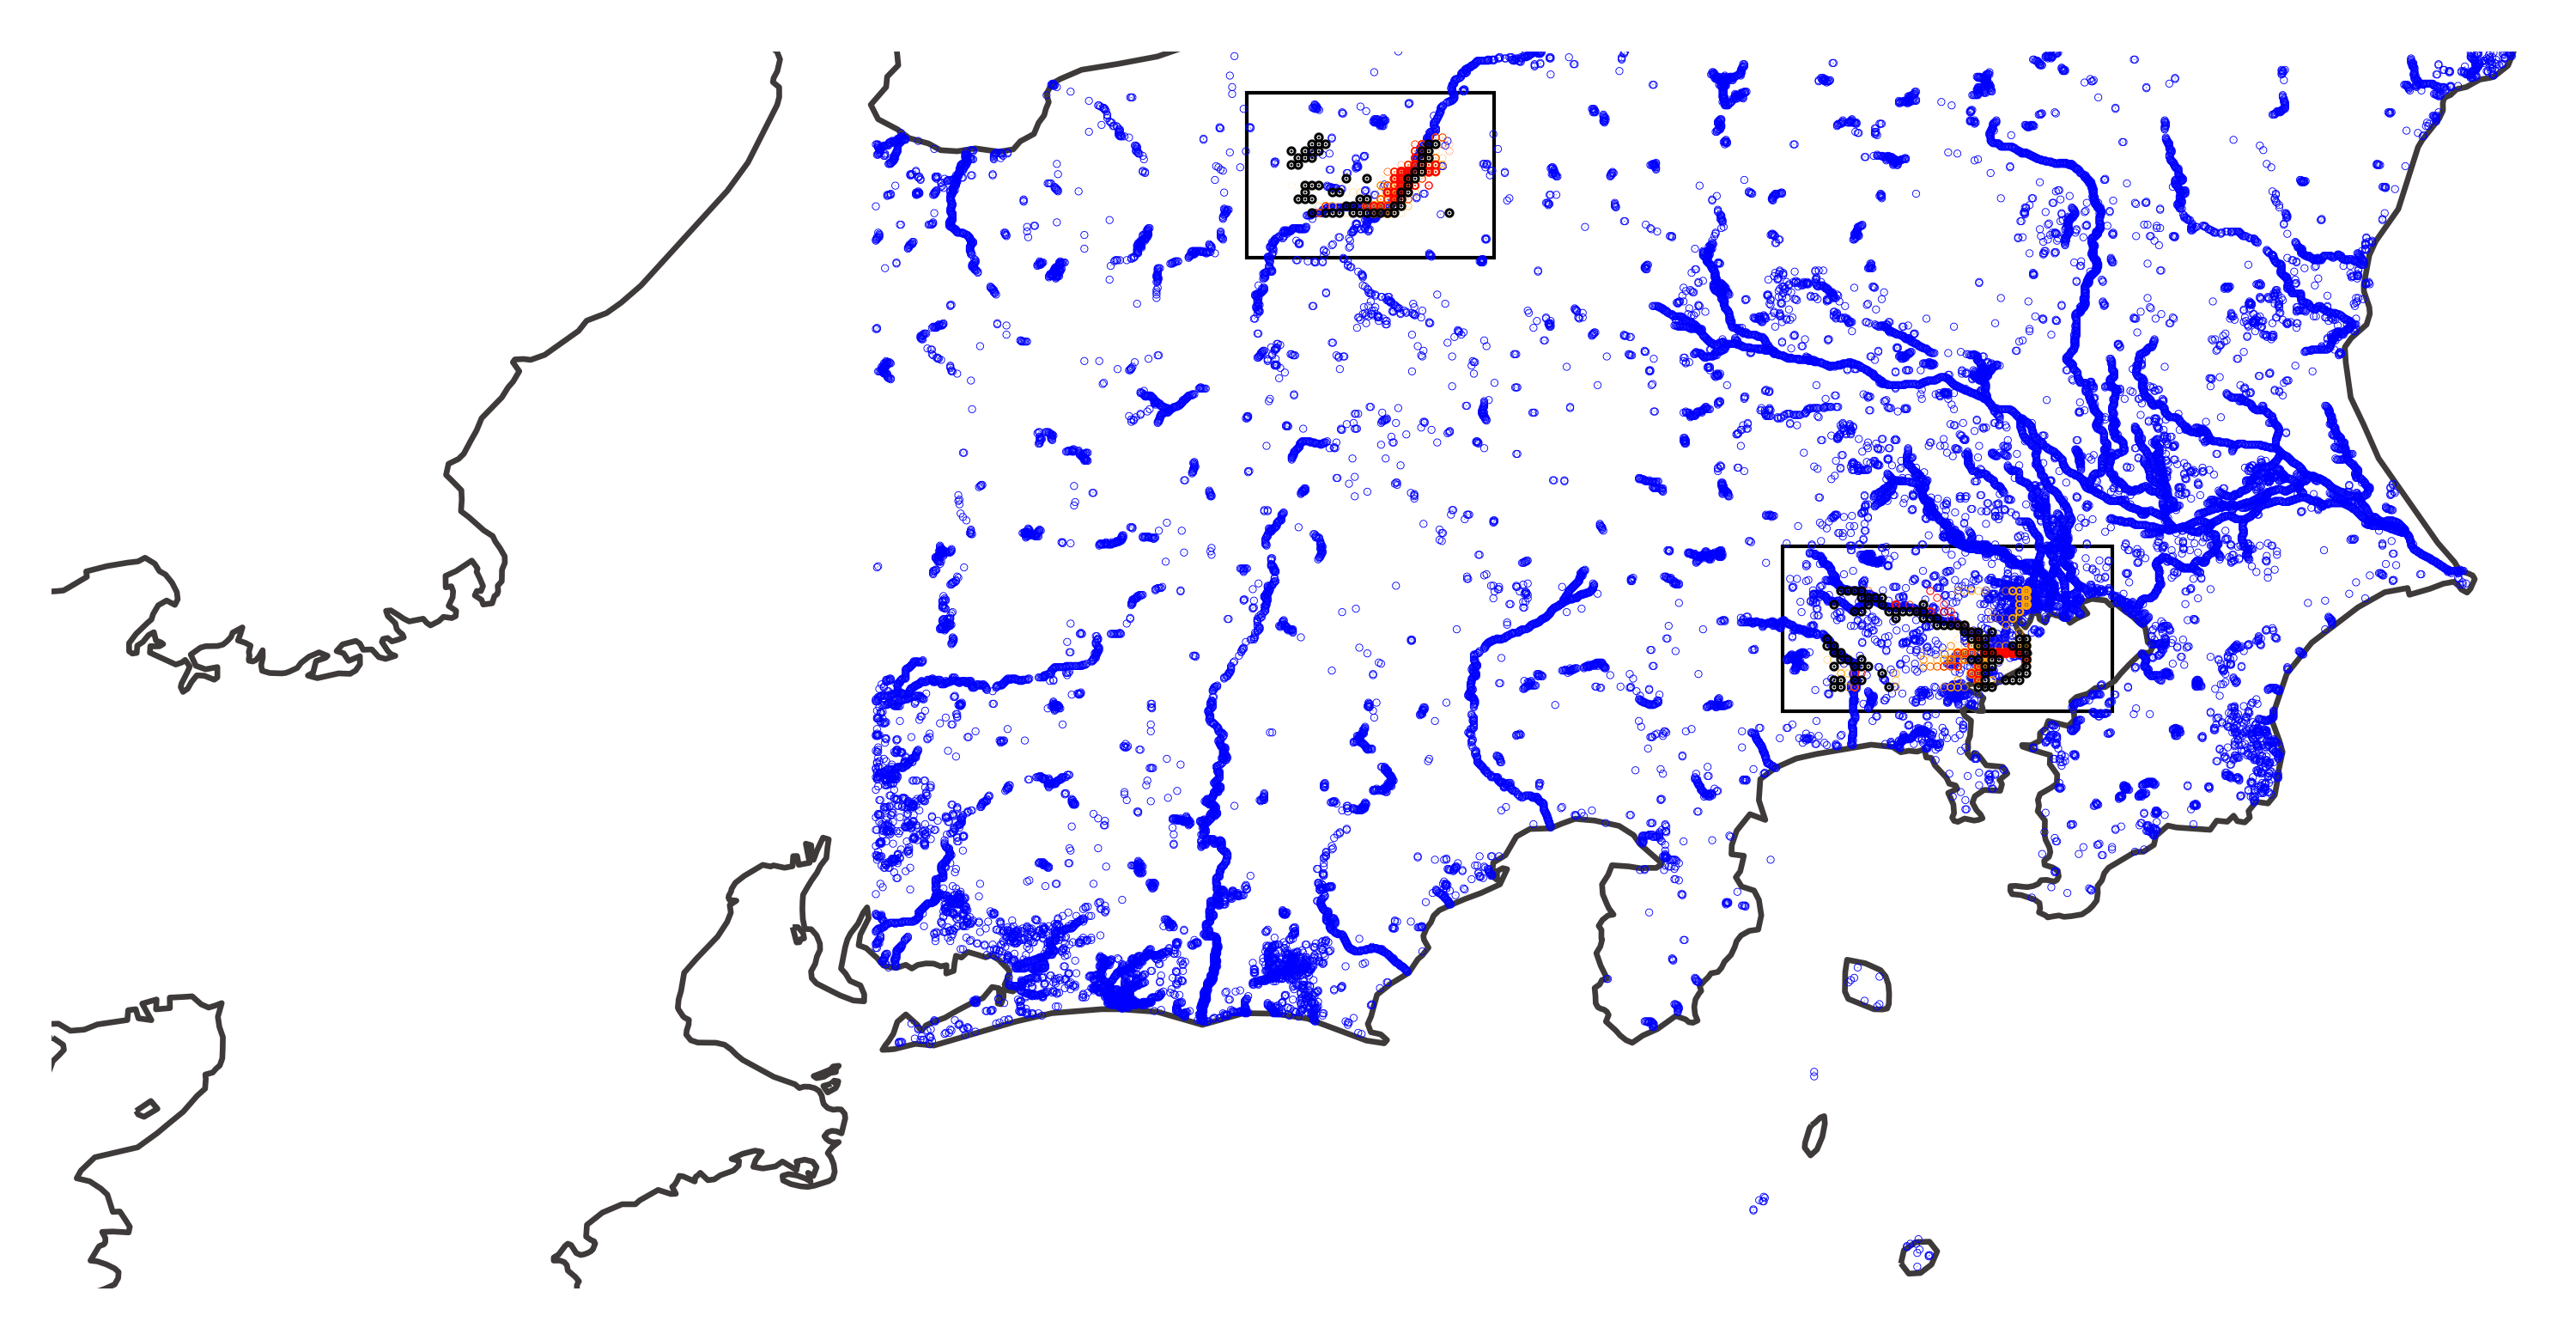

In [118]:
# Figure2: sim flooding map
lon_ret1, lon_ret2,lat_ret1, lat_ret2 = 137.9,138.5,36.5,36.9
lon_ret3, lon_ret4,lat_ret3, lat_ret4 = 139.2,140,35.4,35.8
# lon_ret3, lon_ret4,lat_ret3, lat_ret4 = 139.4,140,35.5,36.3
def draw_sat_fld():
    fig = plt.figure(dpi = 600,figsize=(6,6))
    ax1 = fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
    ax1.set_axis_off()
    ax1.set_extent([135,141,34,37], ccrs.PlateCarree())
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0, linestyle='-.')
    ax1.coastlines(alpha=1.,linestyle='-',color = "#3F3A3A",lw=0.8,resolution='10m')
    # mask the other place
    region_lon1 = [128.06, 128.06,138, 138 ]
    region_lat1 = [41 , 45.95 , 45.95, 41  ]
    region_lon2 = [128.06,128.06,131.4,131.4 ]
    region_lat2 = [34.5,41,41,34.5]
    ax1.fill(region_lon1, region_lat1, color='white', transform=ccrs.PlateCarree(), zorder=10)
    ax1.fill(region_lon2, region_lat2, color='white', transform=ccrs.PlateCarree(), zorder=10)
    cmap = ListedColormap(['blue']) 
    gl.top_labels   = False
    gl.right_labels = False
    gl.bottom_labels= False
    gl.left_labels = False
    # identify region
    # 138-138.4, 36.6-36.8
    # 139.3-139.8, 35.45-35.7
    def add_rect(lon_min, lon_max,lat_min,lat_max):
        rect = Rectangle((lon_min,lat_min), lon_max-lon_min, lat_max-lat_min, linewidth=0.5, edgecolor='black',facecolor='none',transform=ccrs.PlateCarree())
        ax1.add_patch(rect)
    add_rect(lon_ret1, lon_ret2,lat_ret1, lat_ret2)
    add_rect(lon_ret3, lon_ret4,lat_ret3, lat_ret4)
    lon2d_tiff, lat2d_tiff = np.meshgrid(lon_tiff, lat_tiff)
    uparea_reg = np.where(np.isnan(uparea_low),np.nan,0.01)
    ax1.scatter(lon2d_tiff, lat2d_tiff,uparea_reg, c='blue',zorder=2, transform=ccrs.PlateCarree())
    # con_plot1 = ax1.pcolormesh(lon_tiff,lat_tiff,uparea_low,zorder=2, cmap=cmap,alpha=0.35, transform=ccrs.PlateCarree(),vmin=0,vmax=30)  
    fld_up_plot1 = np.where(np.isnan(fld_up1)|(fld_up1<10**(-8)),np.nan,0.5)
    fld_up_plot2 = np.where(np.isnan(fld_up2)|(fld_up2<10**(-8)),np.nan,0.5)
    def draw_sat_reg(lon2d_map,lat2d_map,data,c):
        # control the size for the flooding area
        ax1.scatter(lon2d_map, lat2d_map, data, color=c, zorder=3, transform=ccrs.PlateCarree(),marker='.')
    draw_sat_reg(lon2d_sim1,lat2d_sim1,sim_fld_reg1,'orange')
    draw_sat_reg(lon2d_sim1,lat2d_sim1,da_fld_reg1,'red')
    draw_sat_reg(lon2d_sim2,lat2d_sim2,sim_fld_reg2,'orange')
    draw_sat_reg(lon2d_sim2,lat2d_sim2,da_fld_reg2,'red')
    draw_sat_reg(lon2d_sim1,lat2d_sim1,fld_up_plot1,'black')
    draw_sat_reg(lon2d_sim2,lat2d_sim2,fld_up_plot2,'black')
    # draw_sat_reg(lon2d_map1,lat2d_map1,fld_reg1[::-1,:]*0.05,'black')
    # draw_sat_reg(lon2d_map2,lat2d_map2,fld_reg2[::-1,:]*0.05,'black')
    plt.show()
    # plt.savefig('/work/a06/yingying/Code/plot/online/jupyter/exp_'+exp+dahour_str+'/'+'1_flood'+yyyymmddhh[0:8]+'.jpg', format='jpg',dpi=600)
    plt.close()
draw_sat_fld()

In [108]:
# region compare
def cal_comp_fld(fld_up,sim_fld_reg,da_fld_reg):
    cal_sim_fld = np.zeros((np.shape(sim_fld_reg)[0],np.shape(sim_fld_reg)[1]))
    cal_da_fld  = np.zeros((np.shape(sim_fld_reg)[0],np.shape(sim_fld_reg)[1]))
    cal_fld     = np.full((np.shape(sim_fld_reg)[0],np.shape(sim_fld_reg)[1]),np.nan)
    for i in range(0,np.shape(sim_fld_reg)[0]): # lat
        for j in range(0,np.shape(sim_fld_reg)[1]): # lon
            # simulation condition
            if (fld_up[i,j]<10**(-8)) & (sim_fld_reg[i,j]>10**(-8)):  # only sim
                cal_sim_fld[i,j] = 1
            if (fld_up[i,j]>10**(-8)) & (sim_fld_reg[i,j]>10**(-8)):  # both sim and sat
               cal_sim_fld[i,j] = 2
            if (fld_up[i,j]>10**(-8)) & (sim_fld_reg[i,j]<10**(-8)):  # only sat
                cal_sim_fld[i,j] = 3
            # da condition
            if (fld_up[i,j]<10**(-8)) & (da_fld_reg[i,j]>10**(-8)):  # only da
                cal_da_fld[i,j] = 1
            if (fld_up[i,j]>10**(-8)) & (da_fld_reg[i,j]>10**(-8)):  # both da and sat
               cal_da_fld[i,j] = 2
            if (fld_up[i,j]>10**(-8)) & (da_fld_reg[i,j]<10**(-8)):  # only sat
                cal_da_fld[i,j] = 3
            # 0.5: only sim, 1.5: only da, 2.5: only sat, 3.5: sim+da, 4.5: sim+sat, 5.5: da+sat, 6.5: sim+da+sat, nan: no flood
            if (cal_sim_fld[i,j]==1) & (cal_da_fld[i,j]==0):
                cal_fld[i,j] = 0.5
            if (cal_sim_fld[i,j]==0) & (cal_da_fld[i,j]==1):
                cal_fld[i,j] = 1.5
            if (cal_sim_fld[i,j]==3) & (cal_da_fld[i,j]==3):
                cal_fld[i,j] = 2.5                
            if (cal_sim_fld[i,j]==1) & (cal_da_fld[i,j]==1):
                cal_fld[i,j] = 3.5            
            if (cal_sim_fld[i,j]==2) & (cal_da_fld[i,j]==3):
                cal_fld[i,j] = 4.5                
            if (cal_sim_fld[i,j]==3) & (cal_da_fld[i,j]==2):
                cal_fld[i,j] = 5.5
            if (cal_sim_fld[i,j]==2) & (cal_da_fld[i,j]==2):
                cal_fld[i,j] = 6.5      
    sim1 = np.shape(np.where(cal_sim_fld==1))[1]
    sim2 = np.shape(np.where(cal_sim_fld==2))[1]
    sim3 = np.shape(np.where(cal_sim_fld==3))[1]
    csi_sim  = sim2/(sim1+sim2+sim3)
    da1 = np.shape(np.where(cal_da_fld==1))[1]
    da2 = np.shape(np.where(cal_da_fld==2))[1]
    da3 = np.shape(np.where(cal_da_fld==3))[1]
    csi_da   = da2/(da1+da2+da3)
    print('score sim:',sim1,sim2,sim3,csi_sim,'score_da:',da1,da2,da3,csi_da)
    return cal_fld,cal_sim_fld,cal_da_fld,csi_sim,csi_da
cal_fld1,cal_sim_fld1,cal_da_fld1,csi_sim1,csi_da1 = cal_comp_fld(fld_up1,sim_fld_reg1,da_fld_reg1)
cal_fld2,cal_sim_fld2,cal_da_fld2,csi_sim2,csi_da2 = cal_comp_fld(fld_up2,sim_fld_reg2,da_fld_reg2)

score sim: 65 33 24 0.27049180327868855 score_da: 45 25 32 0.24509803921568626
score sim: 102 48 28 0.2696629213483146 score_da: 35 35 41 0.3153153153153153


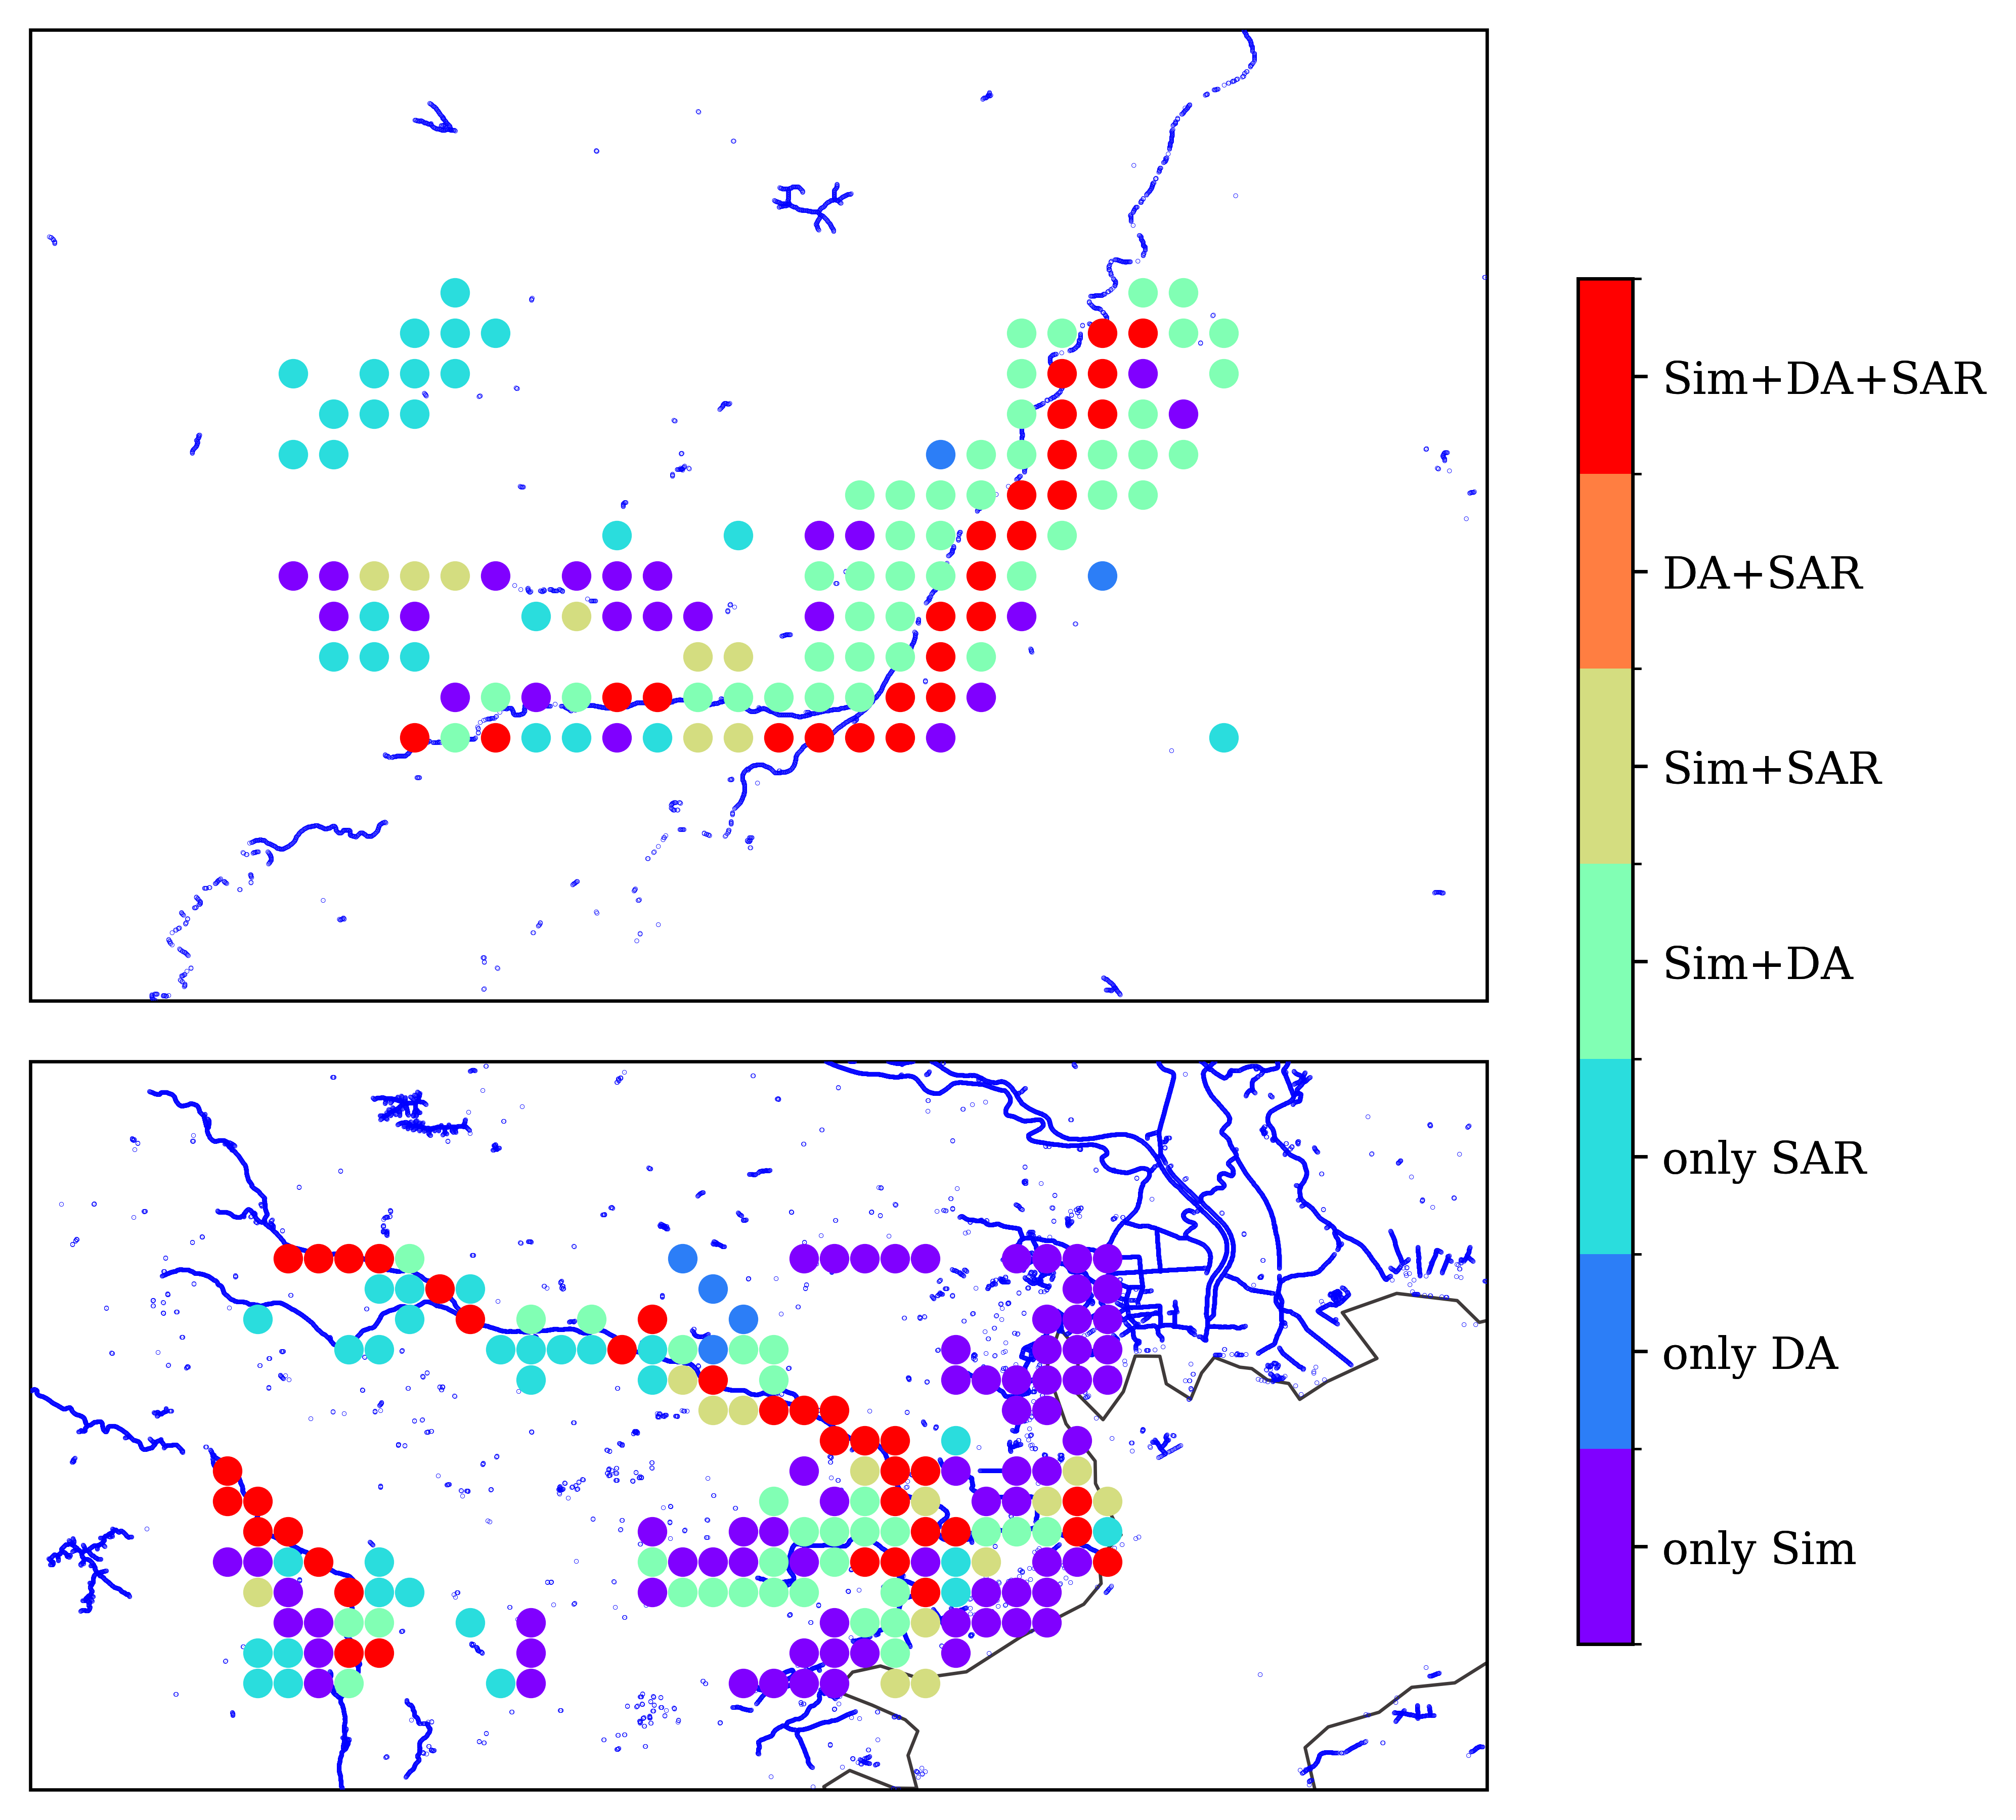

In [119]:
def plot_flood_condition():
    fig = plt.figure(dpi = 600,figsize=(6,6))
    ax1 = fig.add_axes([0,0.5,0.8,0.8],projection=ccrs.PlateCarree())
    ax2 = fig.add_axes([0,0,0.8,0.8],projection=ccrs.PlateCarree())
    def comp_fld(ax1, lon_ret1, lon_ret2,lat_ret1, lat_ret2, lon2d_sim, lat2d_sim, cal_fld):
        ax1.set_extent([lon_ret1, lon_ret2,lat_ret1, lat_ret2], ccrs.PlateCarree())
        gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=1, color='gray', alpha=0, linestyle='-.')
        ax1.coastlines(alpha=1.,linestyle='-',color = "#3F3A3A",lw=0.8,resolution='10m')
        cmap_blue = ListedColormap(['blue']) 
        colors = plt.cm.rainbow(np.linspace(0, 1, 7)) 
        cmap = ListedColormap(colors) 
        bounds = np.arange(0, 8)
        norm = BoundaryNorm(bounds, cmap.N) 
        gl.top_labels   = False
        gl.right_labels = False
        gl.bottom_labels= False
        gl.left_labels = False
        lon_map = np.linspace(lon_min,lon_max,int((lon_max-lon_min)*3600))
        lat_map = np.linspace(lat_min,lat_max,int((lat_max-lat_min)*3600))
        lon_tiff_ind = np.where((lon_map>=lon_ret1)&(lon_map<=lon_ret2))[0]
        lat_tiff_ind = np.where((lat_map>=lat_ret1)&(lat_map<=lat_ret2))[0]
        lat_tiff_reg = lat_map[np.nanmin(lat_tiff_ind):np.nanmax(lat_tiff_ind)+1]
        lon_tiff_reg = lon_map[np.nanmin(lon_tiff_ind):np.nanmax(lon_tiff_ind)+1]
        lon2d_tiff, lat2d_tiff = np.meshgrid(lon_tiff_reg, lat_tiff_reg)
        uparea_reg = up_area[np.nanmin(lat_tiff_ind):np.nanmax(lat_tiff_ind)+1,np.nanmin(lon_tiff_ind):np.nanmax(lon_tiff_ind)+1]
        uparea_reg = np.where(uparea_reg<0.001,np.nan,0.01)
        ax1.scatter(lon2d_tiff, lat2d_tiff,uparea_reg, c='blue',zorder=3, transform=ccrs.PlateCarree())
        # ax1.pcolormesh(lon_tiff_reg,lat_tiff_reg,uparea_reg,zorder=2, cmap=cmap_blue, transform=ccrs.PlateCarree())  
        con_plot2 = ax1.scatter(lon2d_sim, lat2d_sim, c=cal_fld, cmap=cmap, norm=norm, zorder=3, transform=ccrs.PlateCarree())
        def color_bar(l,b,w,h):
          rect = [l,b,w,h]
          cbar_ax = fig.add_axes(rect)
          return cbar_ax
        [l2,b2,w2,h2] = [0.85,0.28,0.03,0.75]
        cbar_ax2 = color_bar(l2,b2,w2,h2)
        cb2 = plt.colorbar(con_plot2, cax=cbar_ax2,orientation="vertical",shrink=0.5)
        cb2.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
        cb2.set_ticklabels(['only Sim','only DA','only SAR','Sim+DA','Sim+SAR','DA+SAR','Sim+DA+SAR'],fontdict=font_label)
    # 0.5: only sim, 1.5: only da, 2.5: only sat, 3.5: sim+da, 4.5: sim+sat, 5.5: da+sat, 6.5: sim+da+sat, nan: no flood
    comp_fld(ax1,lon_ret1, lon_ret2,lat_ret1, lat_ret2, lon2d_sim1, lat2d_sim1, cal_fld1)
    comp_fld(ax2,lon_ret3, lon_ret4,lat_ret3, lat_ret4, lon2d_sim2, lat2d_sim2, cal_fld2)
    plt.show()
    # plt.savefig('/work/a06/yingying/Code/plot/online/jupyter/exp_'+exp+dahour_str+'/'+'2_flood'+yyyymmddhh[0:8]+'.jpg', format='jpg',dpi=600)
    plt.close()
plot_flood_condition()

In [16]:
#%% 24 hour leading time result
offline_path  = '/work/a06/yingying/Code/plot/exp_'+exp+dahour_str+'/'
def read_offline(file,num):
    nf = nc.Dataset(file,'r')
    varname = nf.variables.keys()
    varname = list(varname)
    var = np.array(nf.variables[varname[num]][:])
    var = np.where(var<-1000,np.nan,var)
    var = np.where(var>10**8,np.nan,var)
    return var

def read_fore_nc(loc,type_str,day,hr,varname):
    loc_lat = ilat[loc]
    loc_lon = ilon[loc]
    day_str = '{:02d}'.format(day)
    hr_str  = '{:02d}'.format(hr)
    filepath_24h = '/work/a06/yingying/Code/fore/exp_'+exp+dahour_str+'/'+varname+'/data'+type_str
    ddhh = day_str + hr_str
    file_min = filepath_24h + '_min_'+'01'+ddhh+'.nc'
    file_max = filepath_24h + '_max_'+'01'+ddhh+'.nc'
    file_mean = filepath_24h + '_mean_'+'01'+ddhh+'.nc'
    def read_data(filen):
        nf = nc.Dataset(filen,'r')
        data = np.array(nf.variables['Outflw'])
        data = np.where(data>10**8,np.nan,data)
        return data
    data_min = read_data(file_min)
    data_max = read_data(file_max)
    data_mean = read_data(file_mean)
    min_value  = data_min[:,loc_lat,loc_lon]
    max_value  = data_max[:,loc_lat,loc_lon]
    mean_value = data_mean[:,loc_lat,loc_lon]
    return min_value, max_value, mean_value

def read_simulation(loc):
    loc_lat = ilat[loc]
    loc_lon = ilon[loc]
    # sim/DA
    sim_min_all = list()
    sim_max_all = list()
    sim_mean_all = list()
    da_max_all = list()
    da_min_all = list()
    da_mean_all = list()
    for day in range(day_sta,day_end+1):
        for hr in range(0,24,3):
            sim_min,sim_max,sim_mean = read_fore_nc(loc,'C',day,hr,'rivdph')
            da_min,da_max,da_mean = read_fore_nc(loc,'A',day,hr,'rivdph')
            if var_name == 'rivdph':
                sim_min = sim_min-simmean[loc_lat,loc_lon]
                sim_max = sim_max-simmean[loc_lat,loc_lon]
                sim_mean= sim_mean-simmean[loc_lat,loc_lon]
                da_min  = da_min-simmean[loc_lat,loc_lon]
                da_max  = da_max-simmean[loc_lat,loc_lon]
                da_mean = da_mean-simmean[loc_lat,loc_lon]
            sim_min_all = sim_min_all + [sim_min]
            sim_max_all = sim_max_all + [sim_max]
            sim_mean_all = sim_mean_all + [sim_mean]
            da_min_all = da_min_all + [da_min]
            da_max_all = da_max_all + [da_max]
            da_mean_all = da_mean_all + [da_mean]
    sim_min_all = np.array(sim_min_all)
    sim_max_all = np.array(sim_max_all)
    sim_mean_all = np.array(sim_mean_all)
    da_min_all = np.array(da_min_all)
    da_max_all = np.array(da_max_all)
    da_mean_all = np.array(da_mean_all)
    return sim_min_all, sim_max_all, sim_mean_all, da_min_all, da_max_all, da_mean_all
# read sim/DA data from day_sta -> day_end
# for day in range(day_sta,day_end+1):
#     for hr in range(0,24,3):
#         sim_min,sim_max,sim_mean = read_fore_nc('C',day,hr,'rivdph')
#         da_min,da_max,da_mean = read_fore_nc('A',day,hr,'rivdph')

In [17]:
df  = pd.read_excel("/work/a06/yingying/MLIT/MLIT_FlowGauge_all_info.xlsx",sheet_name='All_locationsV2')
site_name = np.array(df.iloc[:,0])
ref = np.array(df.iloc[:,1])

#%% read the location of observations
file_alloc = 'gauge_good_wlv.txt'
# read allocate information
id_info = list()
ix      = list()
iy      = list()
with open('/work/a06/yingying/obs/alloc/'+file_alloc,'r') as file:
    alloc_info = file.readlines()
    for i in range(1,len(alloc_info)):
        id_info = id_info+[int(alloc_info[i].split()[0])]
        ix      = ix+[int(alloc_info[i].split()[8])-1]
        iy      = iy+[int(alloc_info[i].split()[9])-1]
id_info  = np.array(id_info)
ilon     = np.array(ix)
ilat     = np.array(iy)

def cal_situ_ref(id_info_new):
    ref_new = np.full(np.size(id_info_new),np.nan)
    for i in range(0,np.size(id_info_new)):
        where_ref = np.where(site_name==id_info_new[i])
        ref_new[i]= ref[where_ref]
    ref_new = np.where((ref_new>998.99)&(ref_new<999.5),np.nan,ref_new)
    return ref_new
site_ref = cal_situ_ref(id_info)

#%% read rainfall data
def read_prep(file):
    nf = nc.Dataset(file,'r')
    varname = nf.variables.keys()
    varname = list(varname)
    print(varname)
    lat = np.array(nf.variables[varname[1]][:])
    lon = np.array(nf.variables[varname[2]][:])
    var = np.array(nf.variables[varname[3]][:])
    var = var*3600 # unit: mm/h 
    var = np.array(np.where(var<-900,np.nan,var))
    return lat,lon,var
lat,lon,rainf = read_prep('/work/a06/yingying/ils_data/tej_rain.nc')

/tmp/ipykernel_1715549/4140474867.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ref_new[i]= ref[where_ref]


['time', 'lat', 'lon', 'Precip']


In [25]:
def read_output(exp,dahour_str):
    typeC = "C" # simulation
    output_path  = '/work/a06/yingying/Code/plot/exp_'+exp+dahour_str+'/'
    # [time,lat,lon]
    def read_ens_nc(file):
        nf = nc.Dataset(file,'r')
        varname = nf.variables.keys()
        varname = list(varname)
        var = np.array(nf.variables[varname[3]][:])
        var = np.where(var<-100,np.nan,var)
        return var
    disC_max = read_ens_nc(output_path+var_dep+'/data'+typeC+'_max01_20.nc')
    disC_min = read_ens_nc(output_path+var_dep+'/data'+typeC+'_min01_20.nc')
    return disC_max,disC_min
disC_max,disC_min = read_output(exp,dahour_str)

556 918 304031284416100


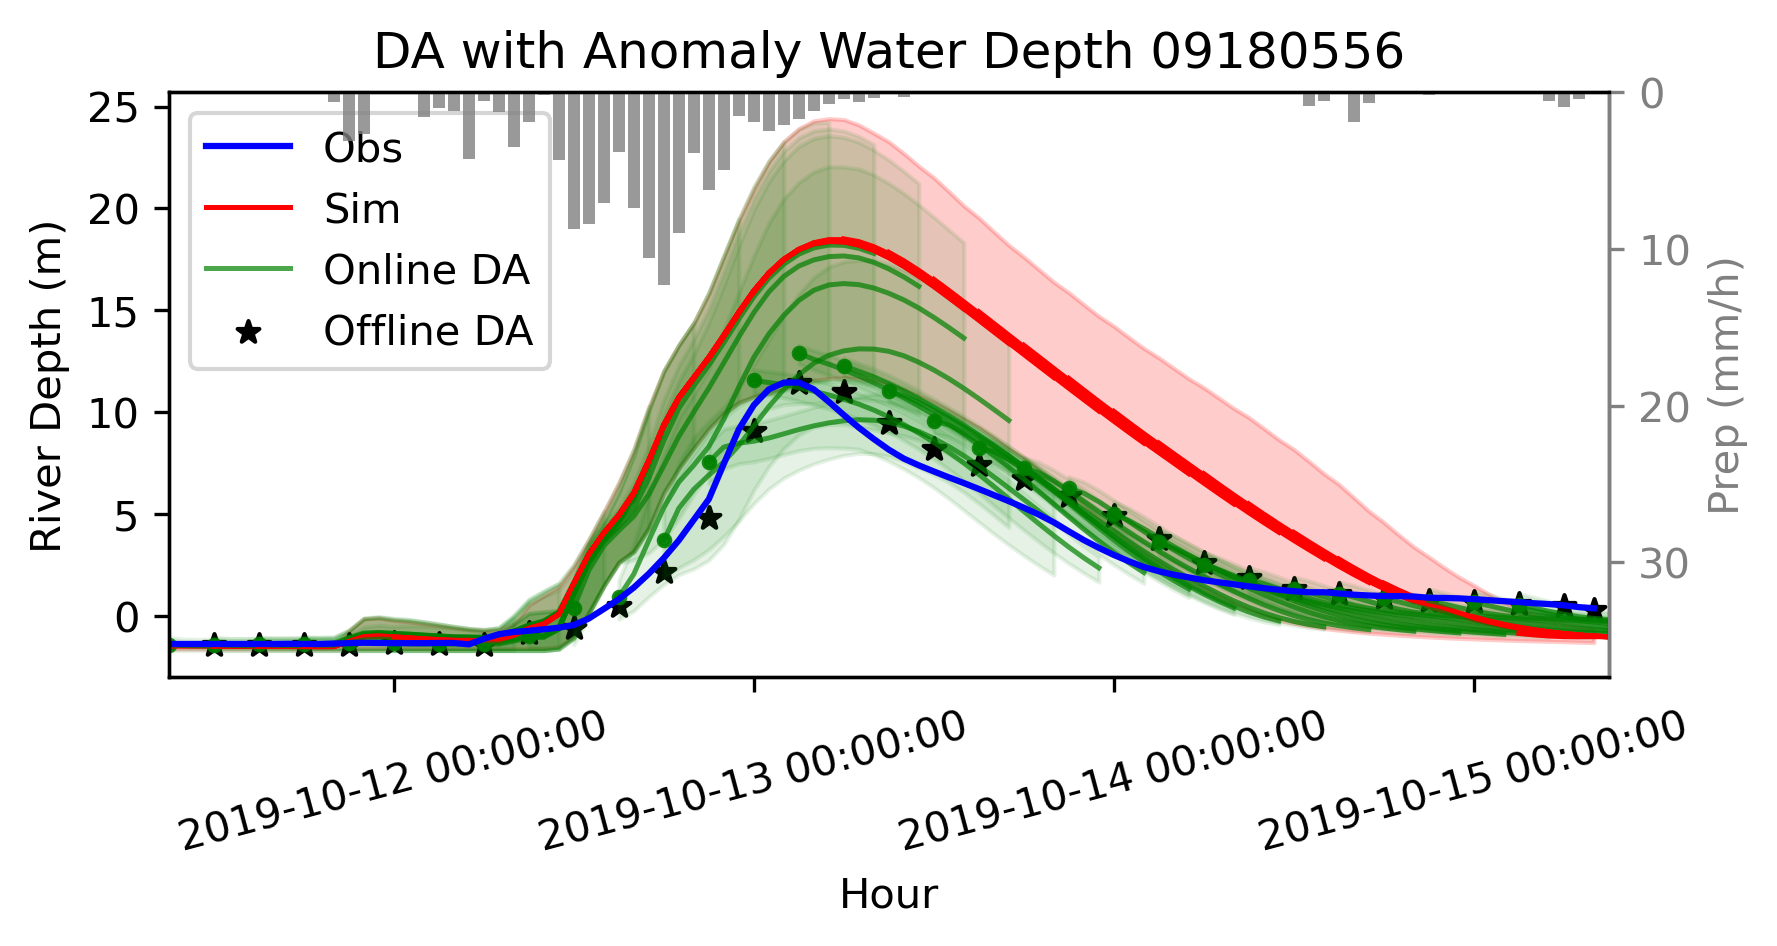

In [133]:
# draw figure with 24h leading time
def draw_lines(loc,loc_lat,loc_lon,ylabel,loc_obs,sim_mean_all,disC_sim_max,disC_sim_min,da_mean_all,da_max_all,da_min_all,locF,rain):
    fig,ax1 = plt.subplots(dpi = 300,figsize=(6,3))
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.25)
    time    = np.arange(0,time_len,1)
    loc_lat = '{:04d}'.format(loc_lat)
    loc_lon = '{:04d}'.format(loc_lon)   
    row_ind = 0
    ax1.fill_between(time, disC_sim_max, disC_sim_min, color='red', alpha=0.2)
    for day in range(0,int((day_end-day_sta+1)*24/dahour)-1):
        time_each = np.arange(day*dahour,(day+1)*dahour,1)
        time_pred = np.arange(day*dahour,day*dahour+24)
        # offline DA
        if var_name == "rivdph":
            ax1.scatter((day+1)*dahour,locF[day], color='black', marker='*', s=30)
        sday = day*dahour
        eday = (day+1)*dahour
        # simulations
        ax1.plot(time_pred,sim_mean_all[row_ind,:],'r-',linewidth=1.2)
        # online DA
        ax1.fill_between(time_pred, da_min_all[row_ind,:], da_max_all[row_ind,:], color='green', alpha=0.1)
        ax1.plot(time_pred,da_mean_all[row_ind,:],'g-',linewidth=1.2,alpha=0.7)       
        time_each_da =np.arange(sday,eday,1)
        ax1.scatter(time_each_da[0],da_mean_all[row_ind,0],marker='.',color='green',alpha=0.9,s=30)
        row_ind = row_ind + 1
    # dis obs
    ax1.plot(time,loc_obs,color='blue',label='Obs',linewidth=1.5)

    # online DA
    day = day+1
    time_each = np.arange(day*dahour,(day+1)*dahour,1)
    ax1.plot(time_pred,sim_mean_all[row_ind,:],'r-',linewidth=1.2,label='Sim')
    ax1.plot(time_pred,da_mean_all[row_ind,:],'g-',linewidth=1.2,alpha=0.7,label='Online DA')
    if var_name == 'rivdph':
        ax1.scatter(time_each[-1],locF[-1], color='black', marker='*', s=30,label='Offline DA')

    ax1.set_xlabel('Hour')
    ax1.set_ylabel(ylabel)
    ax1.set_xlim(0,time_len)
    ax1.set_title('DA with Anomaly Water Depth '+str(loc_lon)+str(loc_lat))    
    ax1.legend(loc='upper left')

    dates = pd.date_range(start='2019-10-12 00:00',end='2019-10-15 08:00',freq='24h')
    ax1.set_xticks(np.arange(15,time_len,24))
    ax1.set_xticklabels(dates,rotation=15)

    ax2 = ax1.twinx()
    ax2.invert_yaxis()
    ax2.bar(time,rain,color='gray',alpha=0.8)
    ax2.set_ylabel('Prep (mm/h)')
    ax2.set_ylim(np.nanmax(rain)+25,0)
    ax2.spines['right'].set_color('gray')
    ax2.yaxis.label.set_color('gray')
    ax2.tick_params(axis='y',colors='gray')
    plt.show()
    # plt.savefig('/work/a06/yingying/Code/plot/online/jupyter/'+exp+dahour_str+'/'+var_dir+'_'+str(loc)+'.jpg', format='jpg',dpi=300)
    plt.close()

def draw_obs(loc1,loc2):
    for loc in range(loc1,loc2):
        loc_lat = ilat[loc]
        loc_lon = ilon[loc]
        loc_ref = site_ref[loc]
        loc_id  = id_info[loc]
        print(loc_lat,loc_lon,loc_id)
        #obs
        obs_path = '/work/a06/yingying/MLIT/data/data_'+var_dir+'_hour2019/'
        filename = obs_path+str(loc_id)+'.bin'
        if os.path.exists(filename):            
            with open(filename, 'rb') as f:
                obs = np.fromfile(f, dtype=np.float64)
                obs = np.where(obs<-900,np.nan,obs)
                obs = np.where(obs>10**7,np.nan,obs)
            sim_min_all, sim_max_all, sim_mean_all, da_min_all, da_max_all, da_mean_all = read_simulation(loc)
            if var_name == 'rivdph':
                dis_obs = obs[stime:stime+time_len]-elvmean[loc_lat,loc_lon]
                disC_sim_max = disC_max[sda_time:sda_time+time_len,loc_lat,loc_lon]-simmean[loc_lat,loc_lon]
                disC_sim_min = disC_min[sda_time:sda_time+time_len,loc_lat,loc_lon]-simmean[loc_lat,loc_lon]
                # read offline DA result
                dataF = read_offline(offline_path+var_name+'/dataF.nc',3)
                disF_loc= dataF[soff_time:soff_time+time_len_off,loc_lat,loc_lon] #offline
            else:
                dis_obs = obs[stime:stime+time_len]
                disF_loc= np.full((int((day_end-day_sta+1)*24/dahour),1320,1500),np.nan) #offline
            rain  = rainf[sda_time:sda_time+time_len,loc_lat,loc_lon]
            draw_lines(loc,loc_lat,loc_lon,var_ylabel,dis_obs,sim_mean_all,disC_sim_max,disC_sim_min,da_mean_all,da_max_all,da_min_all,disF_loc,rain)
        else:
            print('no observation')
        
draw_obs(787,788)

            

In [ ]:
simmean[556,918]

In [31]:
np.nanmax(disC_max)

36.68501